# Python Programming, Visualization and Text Analysis - Final project

## Analysis of Twitter messages

### Author: Viktória Kónya

---

#### **Table of contents:**

1. Introduction and data source
2. Data wrangling
3. Data exploration
4. Sentiment analysis
5. Most frequent words
5. Analyze most common expressions with Word cloud

---

## 1. Introduction and data source

In this project I am going to analyze Twitter messages using the [sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) dataset that I downloaded from Kaggle. The dataset contains 1.6 million tweets from the period between April 4th 2009 and June 25th 2009 that were extracted using the Twitter API. The Tweets have been annoted with the corresponding sentiment which enables us to use the dataset for sentiment detection. In my analysis I used a subset of the messages that were tweeted in May 2009.

The dataset contains the following variables:

* target: the polarity of the tweet  (0 = negative, 4 = positive)
* ids: the unique id of the tweet
* date: the date of the tweet
* flag: it refers to the query. If no such query exists then it is NO QUERY.
* user: it refers to the name of the user that tweeted
* text: it refers to the text of the tweet

My project consists of the following sections. First, I will do some data wangling in order to remove duplicated Tweets and do the necessary recodings. Then I am going to further explore the dataset by looking at some decriptives of the dataset. In the third part, I will first assume that the dataset is not labelled (disregard the 'target' field) and implement sentiment detection using the **VADER** sentiment tool of Python. Then I will compare the sentiments given by my model to the existing actual sentiment of the Tweets (given by the 'target' field). In the forth part, I will implement the necessay preprocessing and analyze the most frequent words with **WordCloud**. Finally, in the last section I will train a sentiment classifier using the **Naive Bayes** algorithm and predict the sentiments of some new Tweets. 

---

Let's first import the necessary dependencies.


In [1]:
# Import packages
import os, pandas as pd, re, seaborn as sns, numpy as np, matplotlib.pyplot as plt, random, pickle
from pathlib import Path
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# For text analysis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
# nltk.download('words')

# For wordcloud
from wordcloud import WordCloud, STOPWORDS

# Set working directory
os.chdir('C:\\Users\\User\\Documents\\GitHub\\Python-Text-Analysis\\Assignments\\Final_project')
datapath = Path.cwd() / 'data' 

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org

## 2. Data wrangling

In this section I am going to import the file and filter for the Tweets that were made in May. Then I will remove the duplicated records, handle the missings (if any exists) and do the necessary feature engineering steps. 

#### 2.1. Import data

In [2]:
# Open file
df_orig = pd.read_csv(datapath / f'twitter_data_noemoticon.csv', delimiter = ',', encoding = "ISO-8859-1")

# Add column names
df_orig.columns = ['target', 'ids', 'date', 'flag', 'user', 'tweet']       
df_orig.head()

# Select subset - May only
df = df_orig[df_orig['date'].str[4:7] == 'May']


The dataset used in my analysis consists of 576.367 Tweets and 6 variables.

In [3]:
df.shape

(576367, 6)

In [4]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
tweet     object
dtype: object

#### 2.2. Duplicates

The first step is that we need to manage the duplicated records. I will use the combination of the user_id and the text of the tweet to detect duplicates.

In [5]:
# Check duplicates
print("Number of duplicates for the ids and tweet: " + str(sum(df.duplicated(subset=['user', 'tweet']))))

Number of duplicates for the ids and tweet: 2099


There are 2099 duplicated Tweets where the user_id and the message is identical. I will remove these Tweets from the dataset.

In [6]:
# Remove duplicates
df = df[~df.duplicated(subset=['user', 'tweet'])]

In [7]:
df.shape

(574268, 6)

#### 2.3. Missings

The next step is that we need to check the number of missing values in all of the fields. In this case it seems that fortunately no fields are impacted by any missing values.

In [8]:
np.sum(df.isnull())

target    0
ids       0
date      0
flag      0
user      0
tweet     0
dtype: int64

#### 2.4. Target

Let's also examine the label which indicates whether the Tweet was annoted as negative or positive. Let's also create a recoded version of the label for the visualizations.

In [9]:
df['target_char'] = np.where(df['target'] == 0, "negative", 
                    np.where(df['target'] == 4, "positive", 
                    "" ))

The proportion of Tweets with positive label is about two-thirds in the dataset.

In [10]:
df.groupby('target_char').agg({'ids':'count'}).rename(columns={'ids':'count'})

,count
target_char,
negative,224241
positive,350027


#### 2.5. Date recoding

For the visualizations I also converted the date of the Tweets to a shorter format.

In [11]:
# Convert date to datetime format
df['dttm'] = pd.to_datetime(df['date'].str[24:28] + ' ' + df['date'].str[4:10], format = '%Y %b %d')
df.head()

,target,ids,date,flag,user,tweet,target_char,dttm
41606,0,1675708196,Fri May 01 20:08:46 PDT 2009,NO_QUERY,jayseto,jayseto@KevinSpacey I loved you in American Be...,negative,2009-05-01
41607,0,1675708308,Fri May 01 20:08:47 PDT 2009,NO_QUERY,QueSarahSarah28,Bad hair day for Sarah.,negative,2009-05-01
41608,0,1675708550,Fri May 01 20:08:49 PDT 2009,NO_QUERY,Babii_Ashh73,It's N-O-N P-H-I-X-I-O-N!!!!!!! Miss my Jedi ...,negative,2009-05-01
41609,0,1675708588,Fri May 01 20:08:49 PDT 2009,NO_QUERY,day_albuquerque,Twitter hate me,negative,2009-05-01
41610,0,1675708597,Fri May 01 20:08:49 PDT 2009,NO_QUERY,michellyy,"did i mention, I miss @gabrielleliorti sorry ...",negative,2009-05-01


#### 2.6. Length of the Tweets

We can also calculate the length (number of characters) for each Tweet.

In [12]:
# Length of tweets
df['tweet_length'] = df['tweet'].str.len()

df.sort_values('user').head()

,target,ids,date,flag,user,tweet,target_char,dttm,tweet_length
1177062,4,1981357110,Sun May 31 08:59:07 PDT 2009,NO_QUERY,000catnap000,this is one of the cartoons i used to watch to...,positive,2009-05-31,110
1042667,4,1957229112,Thu May 28 23:53:20 PDT 2009,NO_QUERY,000catnap000,awake since six o'clock... i had two hours sle...,positive,2009-05-28,106
913714,4,1752675309,Sat May 09 22:37:02 PDT 2009,NO_QUERY,000yea000,thank God we finally found her!,positive,2009-05-09,32
1123218,4,1974462455,Sat May 30 13:11:07 PDT 2009,NO_QUERY,0010x0010,@JoannaGoff Really ? LOL ...no not personally...,positive,2009-05-30,75
905645,4,1695163738,Mon May 04 05:23:34 PDT 2009,NO_QUERY,001BabyGirl,@ianvisagie Why???,positive,2009-05-04,19


The mean length is about 74 characters while we have some extreme long Tweets as well above 200 characters.

In [13]:
df['tweet_length'].agg(['min','max','mean'])

min       6.000000
max     282.000000
mean     73.869775
Name: tweet_length, dtype: float64

For the upcoming visualizations I also created three buckets of the length of the Tweets.

In [14]:
df['tweet_length_category'] = np.where(df['tweet_length'] < 30 , "short (0-30 characters)", 
                      np.where(df['tweet_length'] < 100 , "medium (31-100 characters)",
                      np.where(df['tweet_length'] >= 100 , "long (100+ characters)",         
                      "")))

In [15]:
df.groupby('tweet_length_category').agg({'ids':'count'}).rename(columns={'ids':'count'})

,count
tweet_length_category,
long (100+ characters),156812
medium (31-100 characters),353586
short (0-30 characters),63870


#### 2.7. User activity

Let's also group the users by the number of Tweets they have made for the upcoming analysis.

In [16]:
df['number_of_tweets'] = df.groupby(['user'])['ids'].transform('count')

df['user_activity'] = np.where(df['number_of_tweets'] < 3 , "not_active", 
                      np.where(df['number_of_tweets'] < 50 , "medium_active",
                      np.where(df['number_of_tweets'] >= 50 , "very_active",         
                      "")))

In [17]:
df.groupby('user_activity').agg({'ids':'count'}).rename(columns={'ids':'count'})

,count
user_activity,
medium_active,256209
not_active,307845
very_active,10214


#### 2.8. Remove unnecessary fields

In [18]:
# Remove fields
df.drop('flag', axis=1, inplace=True)

## 3. Data exploration

In this section I will examine some basic characteristics of the Tweets such as their distribution in time and the most active users.

#### 3.1. Number of Tweets by day

Let's first check that which days had the most Tweets. The examined users seem to be more active in the end of the month where the daily number of Tweets exceeded 70.000 messages.

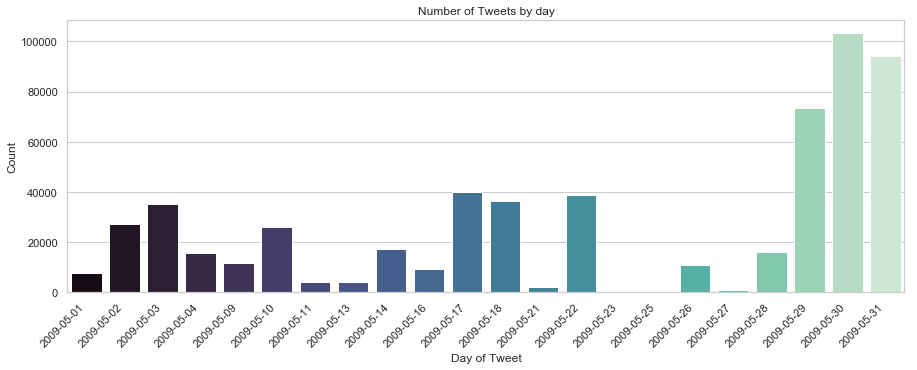

In [19]:
# Number of Tweets by day
df_aggr = df.groupby('dttm').agg({'ids':'count'}).rename(columns={'ids':'count'})
df_aggr.reset_index(inplace=True)
df_aggr

sns.set(rc={"figure.figsize":(15,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot(x='dttm', y='count', data=df_aggr, palette = "mako")
plt.xlabel("Day of Tweet")
plt.ylabel("Count")
plt.title("Number of Tweets by day") 
#fig.xaxis.set_major_locator(ticker.MultipleLocator(5))
x_dates = df['dttm'].dt.strftime('%Y-%m-%d').sort_values().unique()
fig.set_xticklabels(labels=x_dates, rotation=45, ha='right')
plt.show(fig)


#### 3.2. Most active users

Let's also check the top 15 most active users. It seems that the top 4 users made over 150 Tweets during the month.

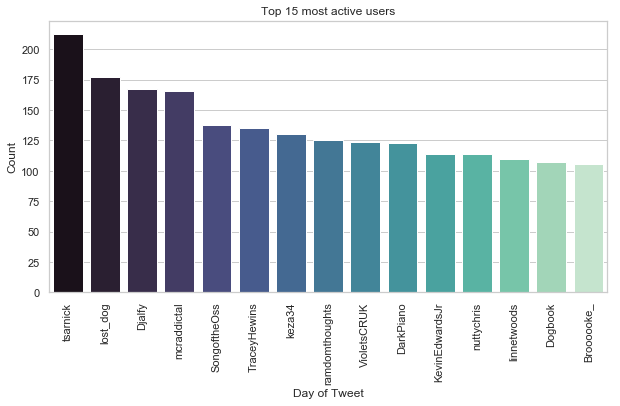

In [20]:
# Most active users
df_aggr = df.groupby('user').agg({'ids':'count'}).rename(columns={'ids':'count'})
df_aggr.reset_index(inplace=True)
df_aggr = df_aggr.sort_values(by = 'count', ascending=False).head(15)

sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot(x='user', y='count', data=df_aggr, palette = "mako")
plt.xlabel("Day of Tweet")
plt.ylabel("Count")
plt.title("Top 15 most active users") 
plt.xticks(rotation=90)
plt.show(fig)

#### 3.3. Distribution of the length of Tweets

Let's also take a look at the length of the Tweets. The average is around 74 characters and we have have a few extreme long Tweets. 

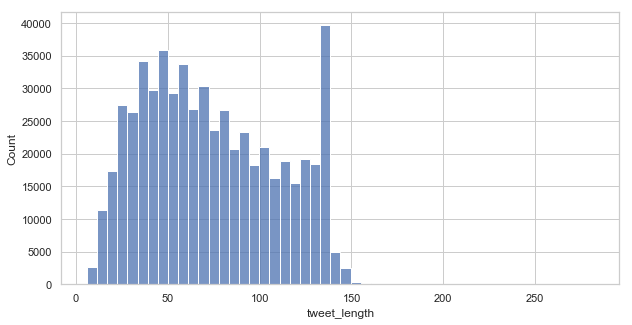

In [21]:
# Distribution of the length of tweets
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
sns.histplot(df['tweet_length'], bins = 50)
plt.show()


## 4. Sentiment analysis

In this part I am going to analyze the sentiments of the Tweets. First, I will assume that there are no sentiment labels in the dataset and using the **VADER** sentiment tool I will assign a sentiment label to each Tweet. Then I will compare the sentiments given by my model to the actual sentiment categories given by the 'target' field in the dataset.

Regarding the text preprocessing I chose to implement minimal modifications in the text. The main reason for that is because standard preprocessing steps (lowercasing a string, removing punctuation, removing stopwords, lemmatizing or stemming strings) can harm the power of VADER and change the output of the model. The first text preprocessing that I am going to implement is that I will substitute the abbreviated expressions with their full text form in order to incorporate more information to the text. Second, I will remove the mentions starting with @ and # and also the hyperlinks as these are unnecessary items for the sentiment detection.

#### 4.1. Text preprocessing

In [22]:
# Create abbreviation dictionary
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# Define abbreviation converter function
def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)  

In [23]:
# Define preprocesser

def text_preprocesser_sentiment(text):
    
    # Remove all mentions (starting with @ or #)
    preprocessed_text = re.sub(r'((@[^, ]*)|(#[^, ]*))', '', text)
    
    # Remove all urls
    preprocessed_text = re.sub(r'((www.[^, ]*)|(https?://[^, ]*))',' ', preprocessed_text)
    
    return preprocessed_text

In [24]:
# Apply abbreviation converter 
df['tweet'] = df['tweet'].apply(lambda x: convert_abbrev_in_text(x))

In [25]:
# Apply text preprocesser
df['tweet_preprocessed_sentiment'] = df['tweet'].apply(text_preprocesser_sentiment)

In [26]:
df.head()

,target,ids,date,user,tweet,target_char,dttm,tweet_length,tweet_length_category,number_of_tweets,user_activity,tweet_preprocessed_sentiment
41606,0,1675708196,Fri May 01 20:08:46 PDT 2009,jayseto,jayseto@KevinSpacey I loved you in American Be...,negative,2009-05-01,130,long (100+ characters),3,medium_active,jayseto I loved you in American Beauty (which ...
41607,0,1675708308,Fri May 01 20:08:47 PDT 2009,QueSarahSarah28,Bad hair day for Sarah.,negative,2009-05-01,24,short (0-30 characters),2,not_active,Bad hair day for Sarah.
41608,0,1675708550,Fri May 01 20:08:49 PDT 2009,Babii_Ashh73,It's N-O-N P-H-I-X-I-O-N!!!!!!! Miss my Jedi M...,negative,2009-05-01,66,medium (31-100 characters),1,not_active,It's N-O-N P-H-I-X-I-O-N!!!!!!! Miss my Jedi M...
41609,0,1675708588,Fri May 01 20:08:49 PDT 2009,day_albuquerque,Twitter hate me,negative,2009-05-01,16,short (0-30 characters),1,not_active,Twitter hate me
41610,0,1675708597,Fri May 01 20:08:49 PDT 2009,michellyy,"did i mention, I miss @gabrielleliorti sorry t...",negative,2009-05-01,86,medium (31-100 characters),5,medium_active,"did i mention, I miss sorry to vent. nothings..."


#### 4.2. Apply sentiment tool

Now we can apply the sentiment analyzer and save the polarity scores.

In [27]:
# Import sentiment library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

# Get polarity scores
df['polarity_score']=df['tweet_preprocessed_sentiment'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])
df['neutral_score'] = df['tweet_preprocessed_sentiment'].apply(lambda x: sentiment.polarity_scores(str(x))['neu'])
df['negative_score'] = df['tweet_preprocessed_sentiment'].apply(lambda x: sentiment.polarity_scores(str(x))['neg'])
df['positive_score'] = df['tweet_preprocessed_sentiment'].apply(lambda x: sentiment.polarity_scores(str(x))['pos'])

df.head()

,target,ids,date,user,tweet,target_char,dttm,tweet_length,tweet_length_category,number_of_tweets,user_activity,tweet_preprocessed_sentiment,polarity_score,neutral_score,negative_score,positive_score
41606,0,1675708196,Fri May 01 20:08:46 PDT 2009,jayseto,jayseto@KevinSpacey I loved you in American Be...,negative,2009-05-01,130,long (100+ characters),3,medium_active,jayseto I loved you in American Beauty (which ...,0.9386,0.524,0.000,0.476
41607,0,1675708308,Fri May 01 20:08:47 PDT 2009,QueSarahSarah28,Bad hair day for Sarah.,negative,2009-05-01,24,short (0-30 characters),2,not_active,Bad hair day for Sarah.,-0.5423,0.533,0.467,0.000
41608,0,1675708550,Fri May 01 20:08:49 PDT 2009,Babii_Ashh73,It's N-O-N P-H-I-X-I-O-N!!!!!!! Miss my Jedi M...,negative,2009-05-01,66,medium (31-100 characters),1,not_active,It's N-O-N P-H-I-X-I-O-N!!!!!!! Miss my Jedi M...,-0.5053,0.621,0.379,0.000
41609,0,1675708588,Fri May 01 20:08:49 PDT 2009,day_albuquerque,Twitter hate me,negative,2009-05-01,16,short (0-30 characters),1,not_active,Twitter hate me,-0.5719,0.351,0.649,0.000
41610,0,1675708597,Fri May 01 20:08:49 PDT 2009,michellyy,"did i mention, I miss @gabrielleliorti sorry t...",negative,2009-05-01,86,medium (31-100 characters),5,medium_active,"did i mention, I miss sorry to vent. nothings...",-0.2263,0.756,0.244,0.000


#### 4.3. Tweets with most positive sentiment

First let's take a look at the Tweets with the highest positive sentiment scores. Note that I displayed here the original Tweet not the preprocessed. I also added a filter criteria for the minimum length of the tweets in order to display meaninful messages.

In [28]:
# Most positive tweets
pd.options.display.max_colwidth = 2000
df[df['tweet_preprocessed_sentiment'].str.len() >= 20].sort_values(by = 'positive_score', ascending=False)['tweet'].head(10)

972763                        @MsKimWilson Yay!! Congratulations!!
1117440                     @yellowspec12 Yay!!! Party Party Party
943404                     @TXNeSs good luck sexy! love love love!
1138645                     freedom!!!!! glorious glorious freedom
953599     Fantastic! Thanks @abysmalred http://tinyurl.com/o66z7j
910593                           @justinsxe woot, woot! super cool
938128                         @sandedfaceless Definitely. Thanks.
1117119                            @ruthseeley Pretty interesting.
1044062                           @grentone Thanks sweetie!.......
999065                             @wyndwitch yay, congratulations
Name: tweet, dtype: object

As we can see the majority of the messages with high positive sentiment score in fact have positive content.

#### 4.4. Tweets with most negative sentiment

Let's look at the Tweets with negative sentiment. Again I filtered for the messages that were at least 15 characters long.

In [29]:
# Most negative tweets
pd.options.display.max_colwidth = 2000
df[df['tweet_preprocessed_sentiment'].str.len() >= 15].sort_values(by = 'negative_score', ascending=False)['tweet'].head(10)

61757                                            @stephenfry Heartbreaking!
1105100                             fuck shit fuck fuck fuck cock fuck shit
211561                                               Tired Sad Bored Lonely
70271                                                   Panic attacks suck!
147929                                          @SethRader unfortunately no
163144     low low low low low low low low low.............................
69466                                                     Painfully tired..
82431                                                 @rossm Ugh, seriously
152804                                      @JewelryTVHost unfortunately no
195089                                                   Seriously confused
Name: tweet, dtype: object

Again, it seems that the sentiment library correctly assigned the negative sentiment scores to the Tweets.

#### 4.5. Assign sentiment class

The next step is that we can assign a sentiment class to every tweet based on the sentiment score that charactarizes it the best. 

If we take a look at the distribution of the compound scores we can see a peak at around 0 which indicates that the vast majority of the Tweets mostly contain neutral words.

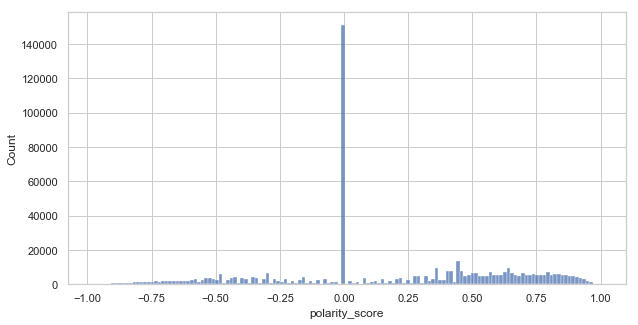

In [30]:
# Distribution of compound scores
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
sns.histplot(df['polarity_score'])
plt.show()

The next step is to define the thresholds for the positive and negative sentiment groups. Tweets that have polarity score (compound score) above 0.05 will be classified as 'positive' and those with polarity score below -0.05 will be classified as 'negative'. The rest of the Tweets will be assigned a 'neutral' sentiment label. 

In [31]:
# Classification
df['sentiment_calc'] = np.where(df['polarity_score'] > 0.05, "positive", 
            np.where(df['polarity_score'] < -0.05, "negative", 
            "neutral"         
            ))

Let's take a look at the distribution of the sentiment categories. It seems that about half of the Tweets mostly contain words with positive sentiment.

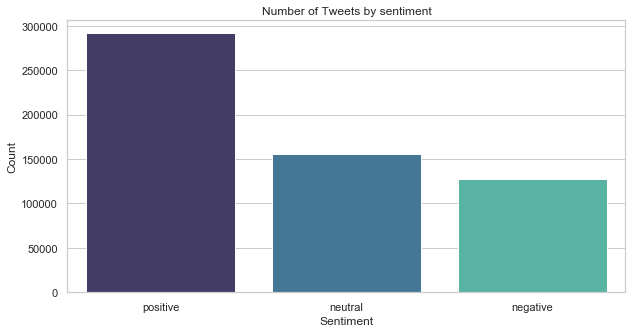

In [32]:
df_aggr = df.groupby('sentiment_calc').agg({'ids':'count'}).rename(columns={'ids':'count'})
df_aggr.reset_index(inplace=True)
df_aggr = df_aggr.sort_values(by = 'count', ascending=False).head(15)

sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot(x='sentiment_calc', y='count', data=df_aggr, palette = "mako")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Number of Tweets by sentiment") 
plt.show(fig)

#### 4.6. Compare sentiment classification to the original sentiment labels

Now we can compare our calculated sentiment classes with the original sentiment labels of the dataset. From the cross table below it seems that about half of the Tweets were similarly labeled. Mostly the originally negative Tweets were misclassified as positive with the VADER sentiment analysis.

In [33]:
pd.crosstab(df["target_char"], df["sentiment_calc"])

sentiment_calc,negative,neutral,positive
target_char,,,
negative,93833,58746,71662
positive,33520,96619,219888


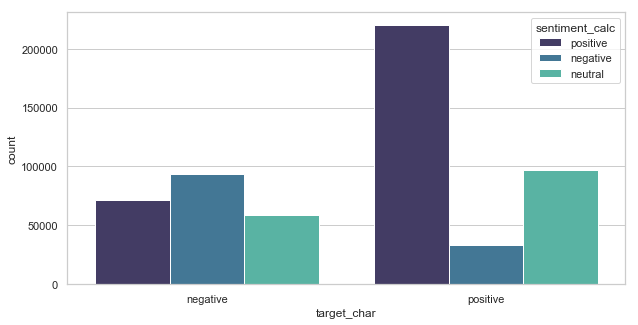

In [34]:
sns.countplot(x='target_char', hue="sentiment_calc", data=df, palette= "mako")

Let's check a few examples of those misclassified cases.

In [35]:
df[ (df["target_char"] == 'negative')  & (df["sentiment_calc"] == 'positive') ].head(5)

,target,ids,date,user,tweet,target_char,dttm,tweet_length,tweet_length_category,number_of_tweets,user_activity,tweet_preprocessed_sentiment,polarity_score,neutral_score,negative_score,positive_score,sentiment_calc
41606,0,1675708196,Fri May 01 20:08:46 PDT 2009,jayseto,jayseto@KevinSpacey I loved you in American Beauty (which is my favourite movie) and I think your AMAZING.... please visit sydney,negative,2009-05-01,130,long (100+ characters),3,medium_active,jayseto I loved you in American Beauty (which is my favourite movie) and I think your AMAZING.... please visit sydney,0.9386,0.524,0.000,0.476,positive
41612,0,1675708915,Fri May 01 20:08:52 PDT 2009,varsharavi,"Please God, make me better again",negative,2009-05-01,33,medium (31-100 characters),1,not_active,"Please God, make me better again",0.7430,0.291,0.000,0.709,positive
41615,0,1675709432,Fri May 01 20:08:56 PDT 2009,concertchristal,"I didn't win the NKOTB contest. But I've met them, and I will again on June 2nd and see them from the 11th row. So I'm good.",negative,2009-05-01,125,long (100+ characters),4,medium_active,"I didn't win the NKOTB contest. But I've met them, and I will again on June 2nd and see them from the 11th row. So I'm good.",0.4992,0.799,0.065,0.136,positive
41619,0,1675709776,Fri May 01 20:08:59 PDT 2009,bella456,@justashley my head is pounding and I got a robot stalker... Hope ur day is better,negative,2009-05-01,83,medium (31-100 characters),17,medium_active,my head is pounding and I got a robot stalker... Hope ur day is better,0.7003,0.691,0.000,0.309,positive
41622,0,1675710310,Fri May 01 20:09:04 PDT 2009,tinkabell8907,misses having all her friends in the same apartment building with her... and always having a free hangout spot... I miss DCP,negative,2009-05-01,125,long (100+ characters),3,medium_active,misses having all her friends in the same apartment building with her... and always having a free hangout spot... I miss DCP,0.5994,0.645,0.125,0.229,positive


#### 4.7. Relationship between the sentiment and the user activity

If we compare the distribution of the Tweets with different sentiments we can see that the majority of the Tweets in each activity class have positive sentiments. Therefore we cannot say that the sentiments of the messages differ by the activity of the users.

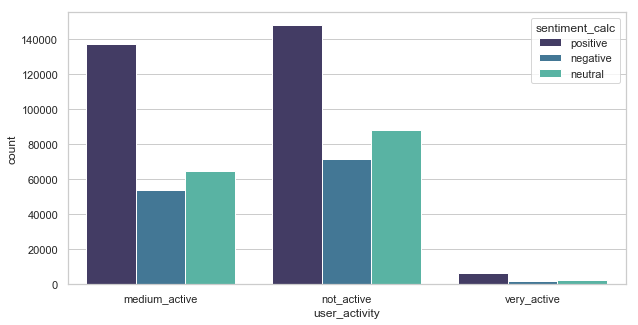

In [36]:
sns.countplot(x='user_activity', hue="sentiment_calc", data=df, palette= "mako")

#### 4.8. Relationship between the sentiment and the length of the Tweet

Can we find more negative messages among longer Tweets? It seems that longer Tweets are either positive or negative but less likely to be neutral. On the other hand, short messages are mostly have neutral sentiments.

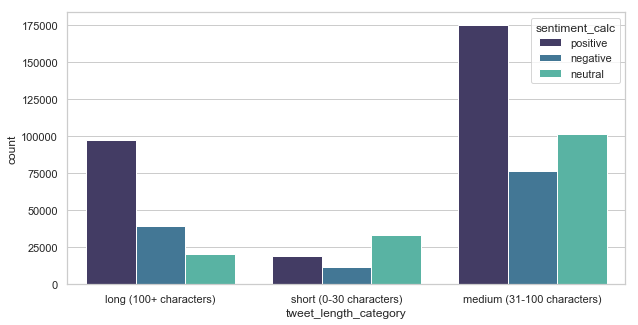

In [37]:
sns.countplot(x='tweet_length_category', hue="sentiment_calc", data=df, palette= "mako")

## 5. Most frequent words

In this section I am going to analyze the most frequent words in the Tweets. My goal is to compare the most common words in the Tweets with positive and negative sentiments. In order to do this, I will first prepare the Tweets by applying a more elaborate text preprocesser. Then I am going to use the **WordCloud** library to identify and visualize the most common words in the Tweets.

#### 5.1. Text preprocessing

I incorporated the following rules to the data preparation:

* Remove all mentions staring with @ or #
* Remove all urls
* Remove all not alphanumerical characters (including punctuations)
* Lowercase 
* Remove words that are less than 2 characters long (eg. u, im)

I am going to use the preprocessed data for the WordCloud therfore I would like to present meaningful words. Because of this I will normalize the words by lemmatization. Similarly to the previous analysis, I will eliminate all the tagged words starting with @ or #. In order to remove these tagged items from the text I first got rid of the whole word that started with either @ or #. Then I also removed all the items that were url links. After that I could remove the special characters (emojis were removed by the creator of the dataset). I also noticed that there were a lot of abbreviations such as 'u' for you or 'im' for I'm so I also removed all the words that were shorter than 2 characters. Finally, I also removed the stopwords and converted the whole text to lowercase.

In [45]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Define preprocesser
def text_preprocesser(text):
    
    # Remove all mentions (starting with @ or #)
    text = re.sub(r'((@[^, ]*)|(#[^, ]*))', '', text)
    
    # Remove all urls
    text = re.sub(r'((www.[^, ]*)|(https?://[^, ]*))',' ', text)
    
    # Remove punctuations
    # text = re.sub(r'[^\w\s]', '', text)
    
    # Remove not alphanumerical characters
    text = re.sub("[^a-zA-Z]+", " ", text)
    
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # Remove words with length less than 2 characters (eg. u, im, )
    tokens = [word for word in tokens if len(word)>2]
        
    
    # Lemmatize
    lemma = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    
    # Join
    preprocessed_text = ' '.join(lemma)
    
    return preprocessed_text

In [ ]:
# NOTE: THIS CHUNK WAS INTENTIONALLY NOT EXECUTED AS THE OUTPUT WAS SAVED BEFORE!
# Apply text preprocesser
df['tweet_preprocessed_lemma'] = df['tweet'].apply(text_preprocesser)

# Save
with open(f'tweets_preprocessed_lemma.p', 'wb') as f:
        pickle.dump(df, f)

In [46]:
with open(f'tweets_preprocessed_lemma.p', 'rb') as data:
    df = pickle.load(data)

#### 4.3. Remove records with zero-length Tweets after the preprocessing

There were some Tweets where the prepocessing removed the full text. I excluded these records from the analysis.

In [47]:
# Check records with zero length Tweet
df[df['tweet_preprocessed_lemma'].str.len() == 0].head()

,target,ids,date,user,tweet,target_char,dttm,tweet_length,tweet_length_category,number_of_tweets,user_activity,tweet_preprocessed_sentiment,polarity_score,neutral_score,negative_score,positive_score,sentiment_calc,tweet_preprocessed_lemma
41729,0,1675754844,Fri May 01 20:15:16 PDT 2009,BrentMcGuire,@HillaryR,negative,2009-05-01,11,short (0-30 characters),1,not_active,,0.0,0.0,0.0,0.0,neutral,
41937,0,1675860363,Fri May 01 20:30:12 PDT 2009,ithinktooomuch,@APairofJean,negative,2009-05-01,13,short (0-30 characters),1,not_active,,0.0,0.0,0.0,0.0,neutral,
41973,0,1675886703,Fri May 01 20:34:00 PDT 2009,jmk1980,@StaceyVPofWC me too,negative,2009-05-01,21,short (0-30 characters),5,medium_active,me too,0.0,1.0,0.0,0.0,neutral,
42010,0,1675896369,Fri May 01 20:35:22 PDT 2009,youngscolla,@thatladyj I wasn't there,negative,2009-05-01,26,medium (31-100 characters),3,medium_active,I wasn't there,0.0,1.0,0.0,0.0,neutral,
42188,0,1675994534,Fri May 01 20:49:45 PDT 2009,yuppCaitlinrae,@coollike http://twitpic.com/4c7ce - owwwie!,negative,2009-05-01,45,medium (31-100 characters),1,not_active,- o,0.0,1.0,0.0,0.0,neutral,


In [48]:
# Remove records where the Tweet has zero length after the preprocessing
df = df[df['tweet_preprocessed_lemma'].str.len() > 0]

In [49]:
df.shape

(570918, 18)

#### 5.2. Wordcloud of the most frequent words in tweets with negative sentiment

Using the prepocessed and lemmatized Tweets we can explore the most commonly used words in the tweets with negative and positive sentiments. First I will plot the 50 most frequent words from the Tweets that were classified as negative. For the sentiment classification I will use the sentiment classes that were created from the polarity scores of the VADER sentiment analysis.

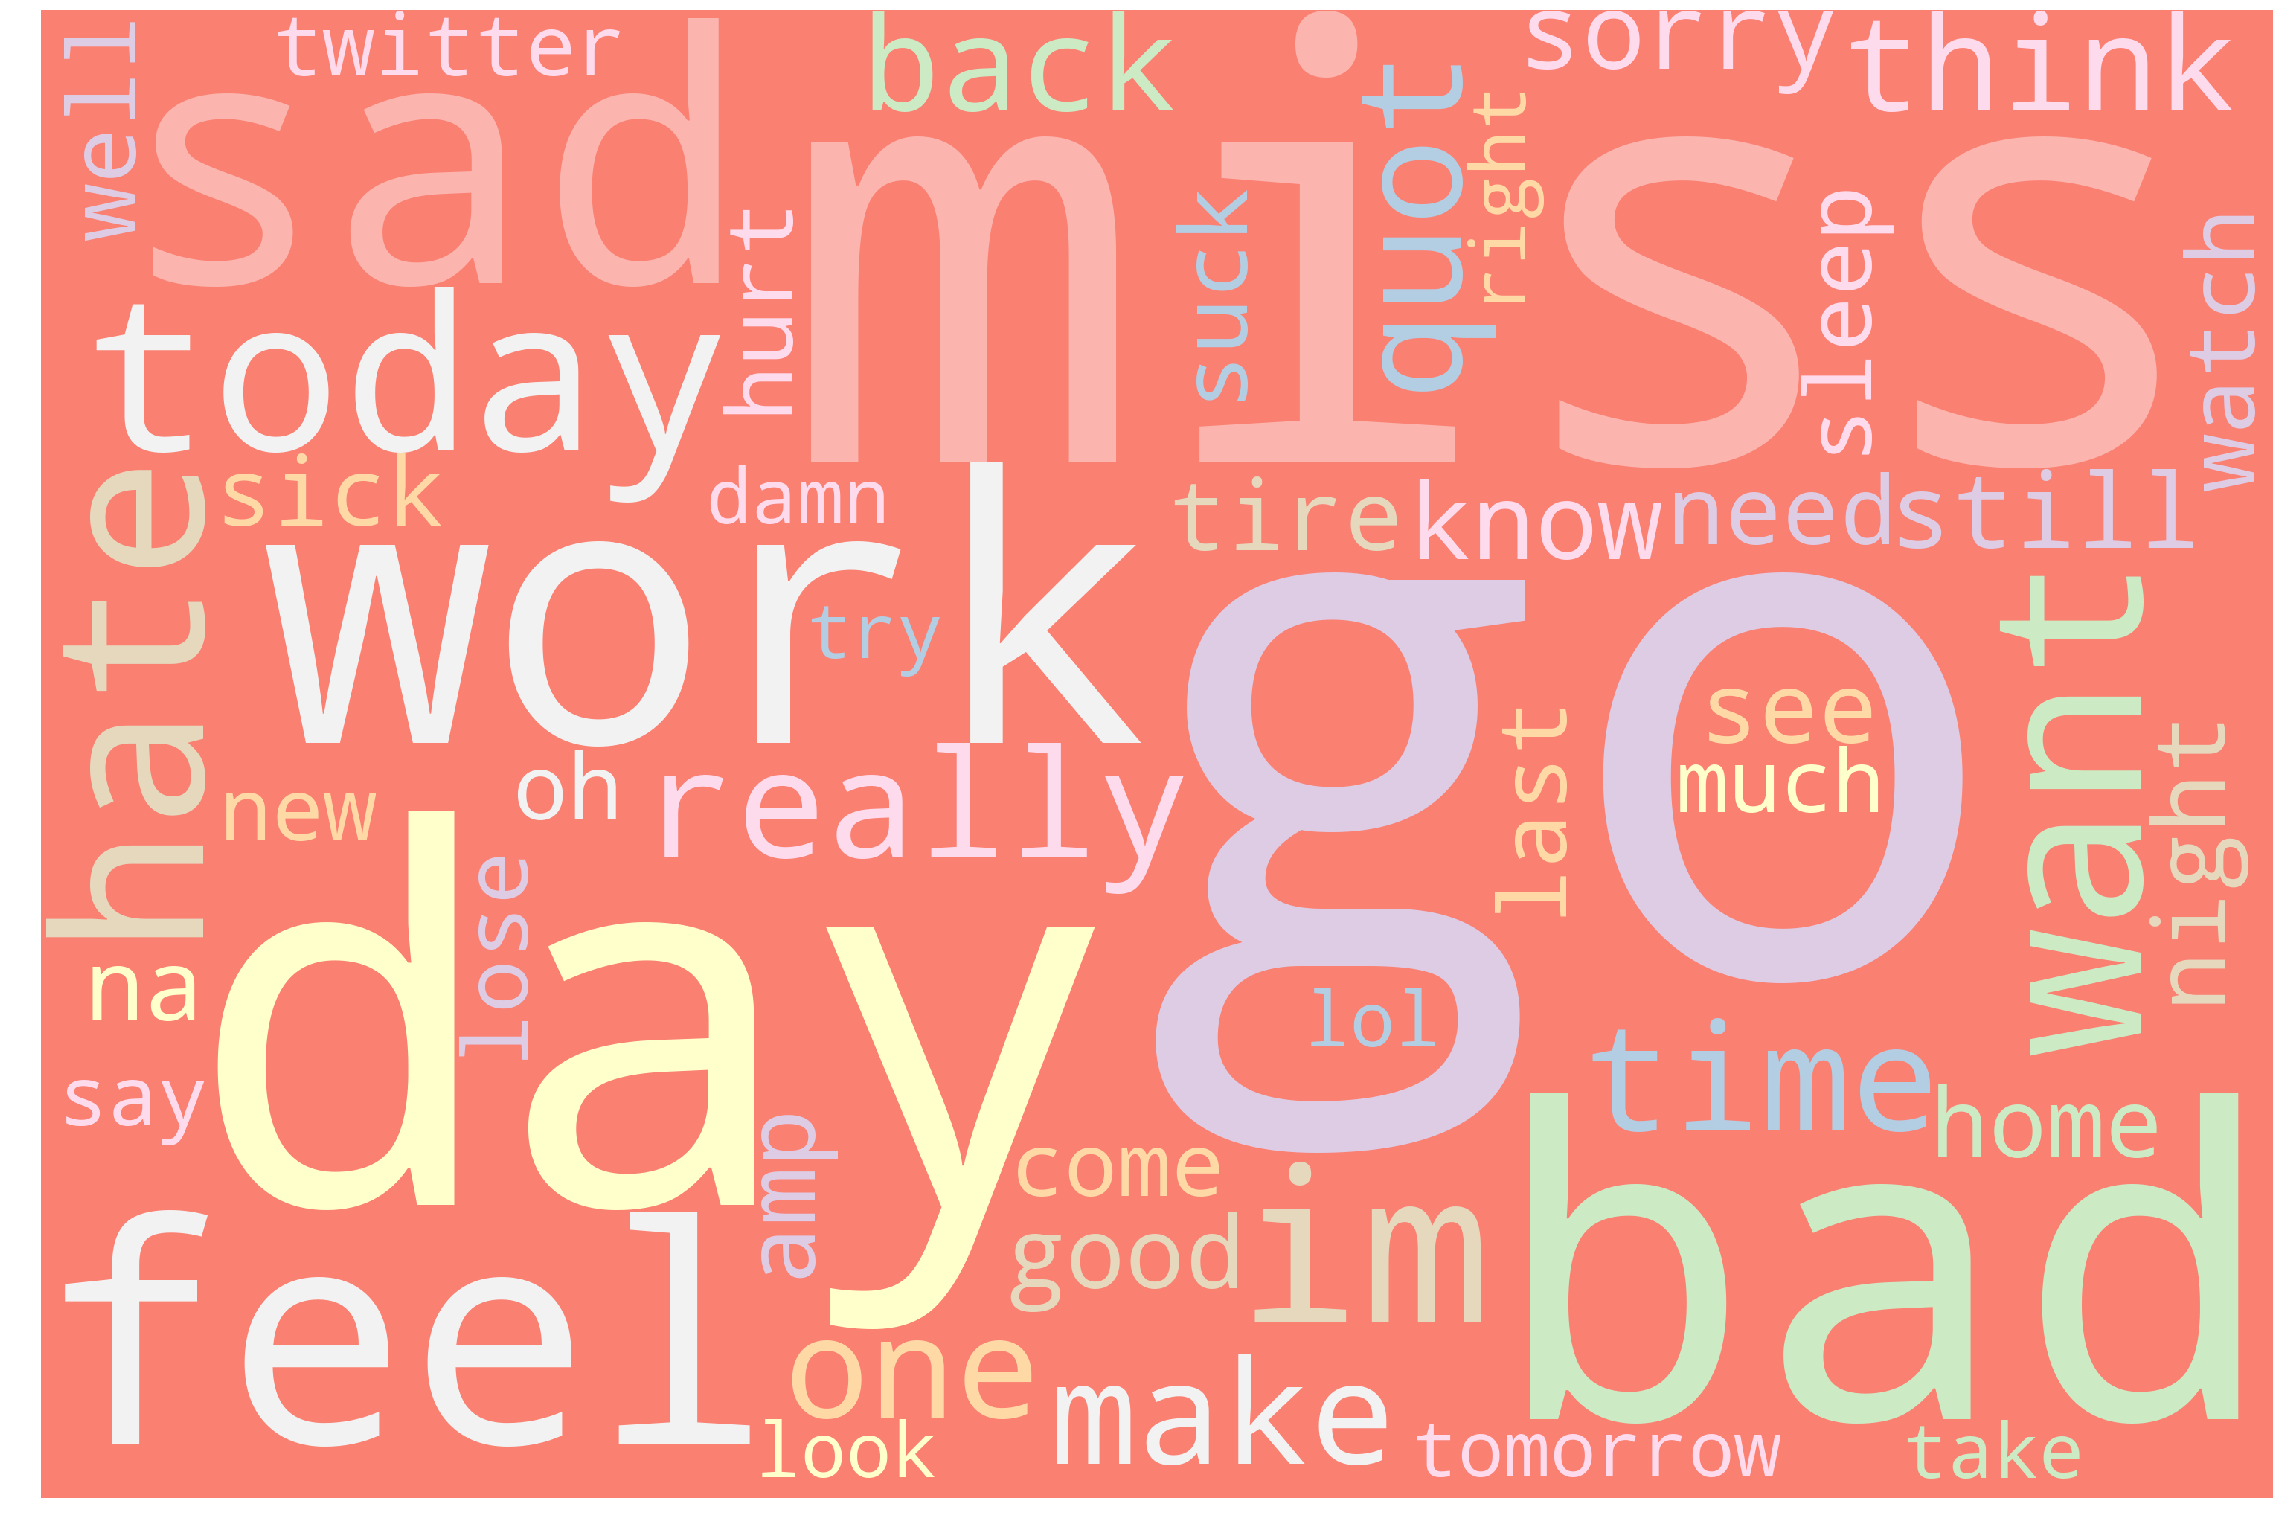

In [43]:
# Concatenate processed speeches
alltweets = ' '.join(df[(df['sentiment_calc']=='negative')]['tweet_preprocessed_lemma'])

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

# Generate word cloud
wordcloud = WordCloud(width= 3000, 
                      height = 2000, 
                      random_state=1, 
                      background_color='salmon', 
                      colormap='Pastel1', 
                      max_words = 50,
                      collocations=False).generate(alltweets)
# Plot
plot_cloud(wordcloud)

Among the most frequent words not surprisingly we can find the miss, work, bad, sad and hate words.

#### 5.3. Wordcloud of the most frequent words in tweets with positive sentiment

In contrast to the most frequent words in the tweets with negative sentiments here we can find words such as good, love, lol, well, thank and haha which confirm the goodness of the previous sentiment analysis.

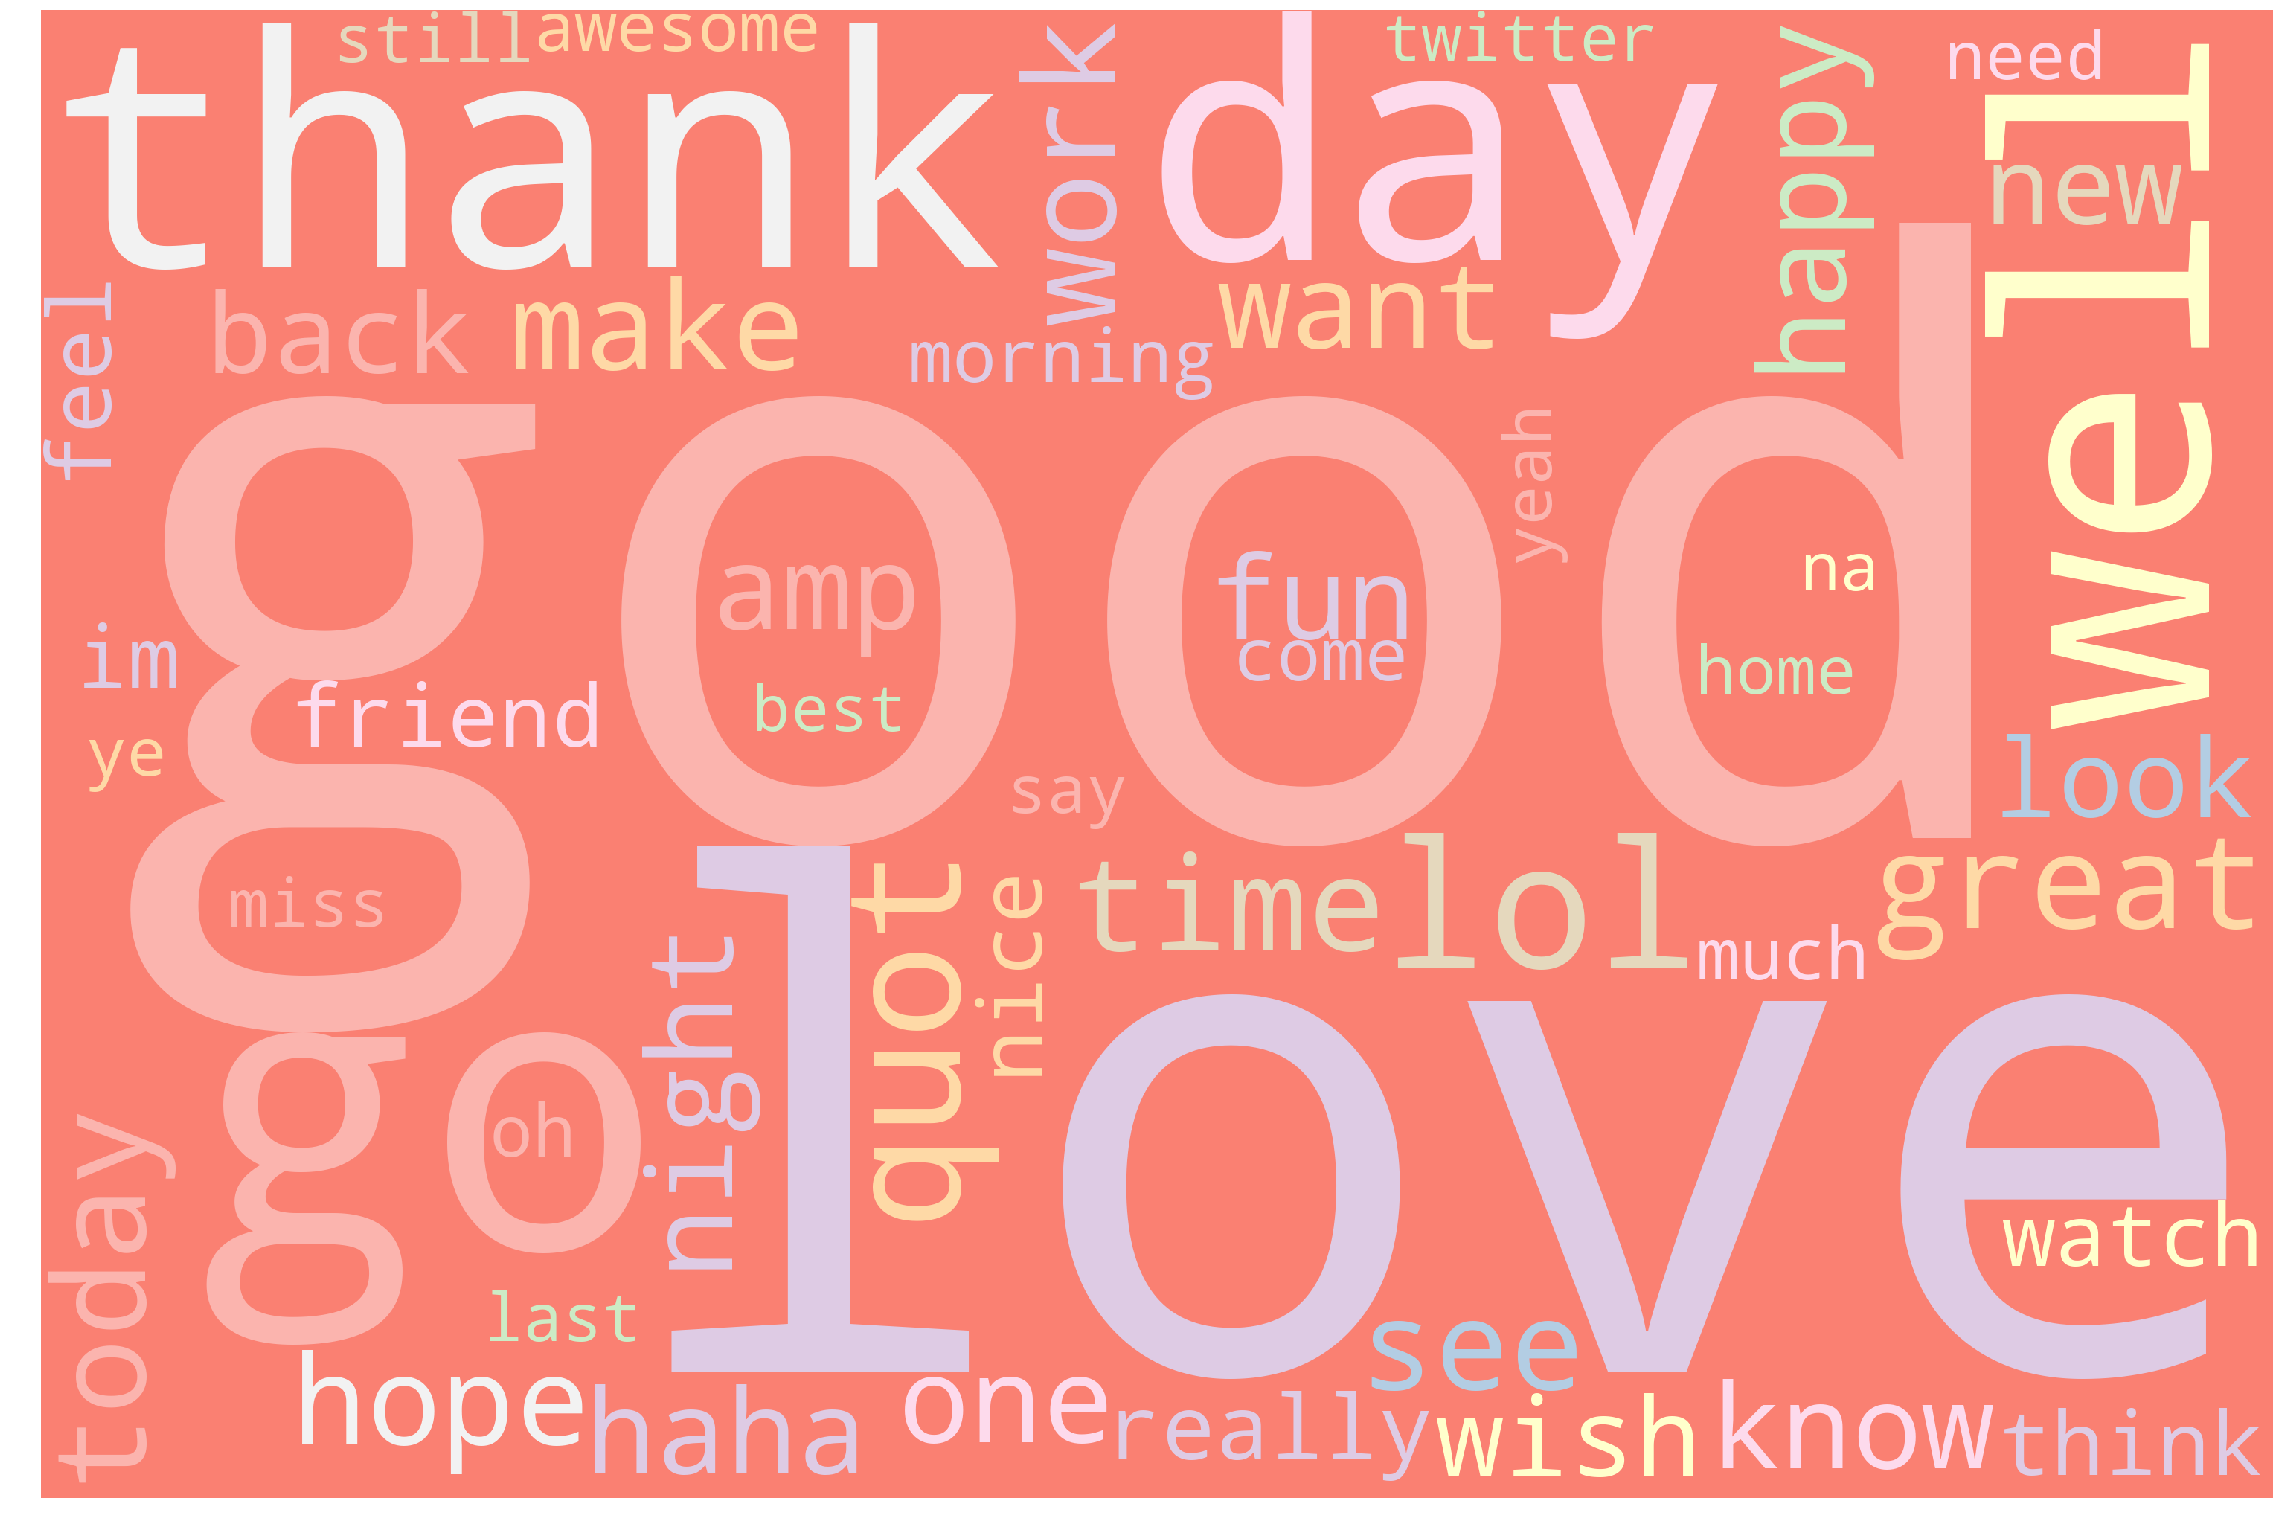

In [44]:
# Concatenate processed speeches
alltweets = ' '.join(df[(df['sentiment_calc']=='positive')]['tweet_preprocessed_lemma'])

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# Generate word cloud
wordcloud = WordCloud(width= 3000, 
                      height = 2000, 
                      random_state=1, 
                      background_color='salmon', 
                      colormap='Pastel1', 
                      max_words = 50,
                      collocations=False).generate(alltweets)
# Plot
plot_cloud(wordcloud)

## 6. Sentiment prediction with Naive Bayes classifier

In this section my goal is to build a prediction model that we can use to detect the sentiments of a new Tweet. In order to do this, I will use the Bag of Words model and extract features from the word occurances. Then I will use the Naive Bayes algorithm for the text classification and evaluate the performance of the model. Finally, using the trained model I will predict the sentiment of some new Tweet messages.

#### 6.1. Distribution of the outcome

In order to decide about which Naive Bayes classifier should be used first let's take a look at the distribution of the outcome variable. In the dataset about two-thirds (64%) of the Tweets have positive label which implies a moderately imbalanced dataset. In order to handle this property of the dataset I will use the Complement Naive Bayes classifier instead of the standard Multinomial Naive Bayes as it is suited for datasets with unequal groups.

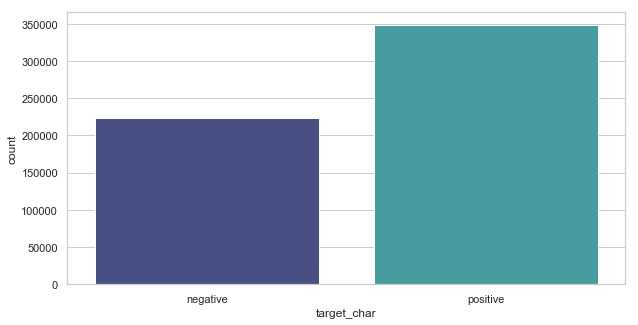

In [72]:
# Outcome
sns.countplot(x='target_char',  data=df, palette= "mako")

#### 6.2. Splitting our data into Train and Test subsets

The next step is that we need to split the data to train and test sets. I will train the model on the former and evaluate its performance on the test set. I chose to keep 80% of the total dataset for the training and use the rest 20% for the evaluation.

In [73]:
from sklearn.model_selection import train_test_split
X=df['tweet']
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=19)

#### 6.3. Building a model pipline

#### 6.2. Feature extraction with the TF-IDF vectorizer

For the feature extraction I will use the TF-IDF vectorizer and maximize the number of features in 100.000. As the input of the vectorizer I used the already preprocessed and lemmatized text that I utilized for the WordClouds.

In [74]:
# Apply TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range = (1,1), preprocessor = text_preprocesser, max_features = 100000)), 
    ('classifier', ComplementNB()),  
])

#### 6.4. Apply model

Let's fit the model.

In [ ]:
pipeline.fit(X_train, y_train)

Let's take a look at the vectorized dataset.

#### 6.5. Model evaluation

We can now evaluate the model on the test set. For the evaluation I will use the F1 score and will also report the confusion matrix in order to detect the misclassified cases.

In [70]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from math import *

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

The macro average F1 score is calculated by taking the unweighted (arithmetic) mean of all the per class F1 scores. In this case both classes are equally important therefore I will use the macro F1 score for the model evaluation. From the below output we can see that the accuracy of the model is about 75% so three-forth of the Tweets were classified correctly. From the confusion matrix we can see that 10.7% of the in fact negative Tweets were labelled as positive by the model (false positive) wile 13.6% were incorrectly classified as negative while these messages contained text with positive sentiments.

              precision    recall  f1-score   support

           0       0.64      0.51      0.57        84
           4       0.69      0.79      0.74       116

   micro avg       0.68      0.68      0.68       200
   macro avg       0.67      0.65      0.65       200
weighted avg       0.67      0.68      0.67       200



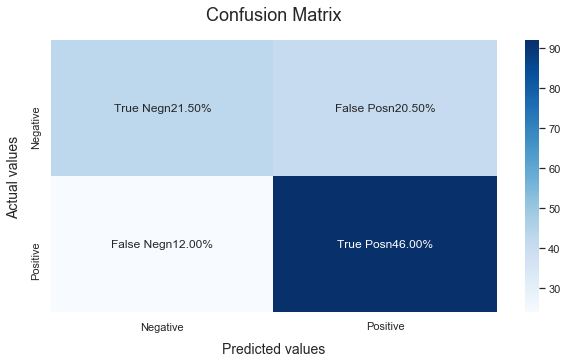

In [71]:
model_Evaluate(pipeline)

#### 6.6. Predicting sentiments of new Tweets

In [ ]:
# Select subset - June
df_new = df_orig[df_orig['date'].str[4:7] == 'Jun'].sample(5)
df_new = df_new[['tweet']]

In [ ]:


cnb = ComplementNB()
cnb.fit(X_train, y_train)

In [ ]:
# Apply transformations
df_new['tweet_preprocessed'] = df_new['tweet'].apply(lambda x: convert_abbrev_in_text(x)) # abbreviation converter
df_new['tweet_preprocessed_lemma'] = df_new['tweet_preprocessed'].apply(text_preprocesser) # text preprocesser
df_new.head()

In [ ]:
# Apply TF-IDF vectorizer
tfidf_new = tfidf_vectorizer.fit_transform(df_new['tweet_preprocessed_lemma'].values.astype('U'))

In [ ]:
tfidf_new.shape

In [ ]:
cnb.predict(tfidf_new)

In [ ]:
from sklearn.pipeline import Pipeline
[pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor = text_preprocesser )),  # integer counts to weighted TF-IDF scores (preprocessing, type of matrix - can pass here the count vectorizer)
    ('classifier', MultinomialNB()),  #Naive Bayes classifier
])]

In [ ]:
predictions = cnb.predict(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.05, max_df= 0.95) # preprocessing was done before
tfidf = tfidf_vectorizer.fit_transform(df['tweet_preprocessed_lemma'])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer()

In [ ]:

bow_transformer = CountVectorizer(preprocessor = remove_stopwords).fit(data['message'])
data_bow = bow_transformer.transform(data['message'])
data_tfidf = tfidf_transformer.transform(data_bow)


from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB()
spam_detect_model.fit(data_tfidf.toarray(), data['label'])

In [ ]:
#x###################################################################################################

In [ ]:
# Convert to df
df_tfidf = pd.DataFrame(tfidf.toarray().transpose(), index=tfidf_vectorizer.get_feature_names())
df_tfidf.head(10)

In [ ]:
from sklearn.model_selection import train_test_split
X=tfidf
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=19)

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import *


cnb = ComplementNB()
cnb.fit(X_train, y_train)
cross_cnb = cross_val_score(cnb, X, y,n_jobs = -1)
print("Cross Validation score = ",cross_cnb)                
print ("Train accuracy ={:.2f}%".format(cnb.score(X_train,y_train)*100))
print ("Test accuracy ={:.2f}%".format(cnb.score(X_test,y_test)*100))
train_acc_cnb=cnb.score(X_train,y_train)
test_acc_cnb=cnb.score(X_test,y_test)

In [ ]:
####################################################
from sklearn.pipeline import Pipeline # allows us 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
#create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=0.05, max_df= 0.95, ngram_range = (1,1))),  # integer counts to weighted TF-IDF scores (preprocessing, type of matrix - can pass here the count vectorizer)
    ('classifier', ComplementNB()),  #Naive Bayes classifier
])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['tweet_preprocessed_lemma'], df['target'], test_size=0.20,random_state=19)

In [ ]:
#Now we can directly pass message text data and the pipeline will do our pre-processing for us!
pipeline.fit(X_train, y_train) # fit on the train set
predictions = pipeline.predict(X_test) # predict on the test set

In [ ]:
print (classification_report(y_test,  predictions)) # true, predicted

In [ ]:
from sklearn.metrics import confusion_matrix
#tn, fp, fn, tp = confusion_matrix(label_test,predictions).ravel()
predictions = cnb.predict(X_test)
confusion_matrix(y_test, predictions)
# FN is zero (1: )